In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import folium
from geopy.geocoders import Nominatim
from IPython.display import Markdown, display
from get_coords import get_city_coordinates

In [2]:
file_path = "/Users/manickr/Github_codes/earth_data/world_temperature_data/ghcnm.tavg.v4.0.1.20250108.qcf.inv"

city_name = "New York"

try:
    center_lat, center_long, lat_min, lat_max, long_min, long_max = get_city_coordinates(city_name, bounds = 0.5)
    print(f"Center coordinates of {city_name}:")
    print(f"Latitude: {center_lat}, Longitude: {center_long}")
except ValueError as e:
    print(e)

m = folium.Map(location = [center_lat, center_long], zoom_start = 8) # We use folium for Map region display

sites = [] 

with open(file_path, "r") as file:
    for line in file:
            site_id = line[:11].strip() # side ID is the first 11 characters
            latitude = float(line[12:20].strip()) #lat is between cols 12-20
            longitude = float(line[21:30].strip()) #longitudes is between cols 21-30
            
    # Now we check if there are temp. collection sites in the selected region
            if lat_min <= latitude <= lat_max and long_min <= longitude <= long_max:
                sites.append(site_id)
                folium.Marker(
                    location = [latitude, longitude],
                    popup = f"Site ID: {site_id}",
                    icon = folium.Icon(color = "blue", icon = "info-sign")
                ).add_to(m)
            

# print("Site IDs:")
# for site in sites:
#     print(site)


# Add the bounding box as a rectangle
folium.Rectangle(
    bounds=[[lat_min, long_min], [lat_max, long_max]],
    color='red',
    weight=2,
    fill=True,
    fill_opacity=0.1
).add_to(m)

# Add a marker for the center point
folium.Marker(
    location=[center_lat, center_long],
    popup="Center Point (Grenoble)",
    icon=folium.Icon(color="green", icon="star")
).add_to(m)

m # show folium plot and data collection sites within selected Region


Center coordinates of New York:
Latitude: 40.7127281, Longitude: -74.0060152


In [3]:
# Now we load the file with the year and temperature data 
data_file = "/Users/manickr/Github_codes/earth_data/world_temperature_data/ghcnm.tavg.v4.0.1.20250108.qcf.dat"

sites_ids_temp = []

with open(data_file, "r") as file_data:
    for line_d in file_data:
        site_id_data = line_d[:11].strip()
        temperature = line_d[20:24]
        year = line_d[11:15]
        if site_id_data in sites:
            sites_ids_temp.append((site_id_data, year, temperature))
            

In [4]:
# Extract years and temperatures
years = np.array([float(entry[1]) for entry in sites_ids_temp])  # Convert years to floats
temperatures = np.array([float(entry[2]) for entry in sites_ids_temp])  / 100 # for degrees celcius  # Convert temperatures to floats

mask_years = (years >= 1960) & (years <= 2024) # include only these as data generally not good below 1960
mask_temp = (temperatures > -60) & (temperatures < 60)
combined_mask = mask_years & mask_temp
filtered_years = years[combined_mask]
filtered_temperatures = temperatures[combined_mask]

In [5]:
from collections import defaultdict
from scipy.stats import linregress
import bootstrap_err

# Extract years and temperatures
years = filtered_years
temperatures = filtered_temperatures

# Total increase in temperature
total_increase = temperatures[-1] - temperatures[0]

# Rate of increase (per year)
years_range = years[-1] - years[0]
rate_of_increase = total_increase / years_range

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(filtered_years, filtered_temperatures)

# Generate x values for the fitted line (from 1960 to 2024)
fitted_years = np.linspace(1960, 2024, 100)  # Smooth range of years
fitted_temperatures = slope * fitted_years + intercept  # Calculate fitted y values
std_data = np.std(filtered_temperatures)
mean_temp = np.mean(filtered_temperatures)

# Define the 5-sigma bounds, and exclude outliers outide this bound
lower_bound = mean_temp - 5 * std_data
upper_bound = mean_temp + 5 * std_data

# Filter out data points outside the 5-sigma range
filtered_indices = (filtered_temperatures >= lower_bound) & (filtered_temperatures <= upper_bound)
filtered_years = filtered_years[filtered_indices]
filtered_temperatures = filtered_temperatures[filtered_indices]

std_lower_bound = fitted_temperatures - std_data
std_upper_bound = fitted_temperatures + std_data

# We create a boostrap distribution to get good estimates of the errors in the fit values
bootstrap_results = bootstrap_err.bootstrap_regression(filtered_years, filtered_temperatures, n_iterations = 1000, confidence_level = 0.95)

slope_ci = bootstrap_results["slope_ci"]
intercept_ci = bootstrap_results["intercept_ci"]

err_slope = (slope_ci[0] + slope_ci[1]) / 2 # Take the average as err

# Total increase in temperature (1960 to 2024)
start_year_temp = slope * 1960 + intercept  # Temperature in 1960 based on fit
end_year_temp = slope * 2024 + intercept    # Temperature in 2020 based on fit
total_increase = end_year_temp - start_year_temp

# Rate of increase in temperature per year
rate_of_increase = slope  # This is the slope from the regression

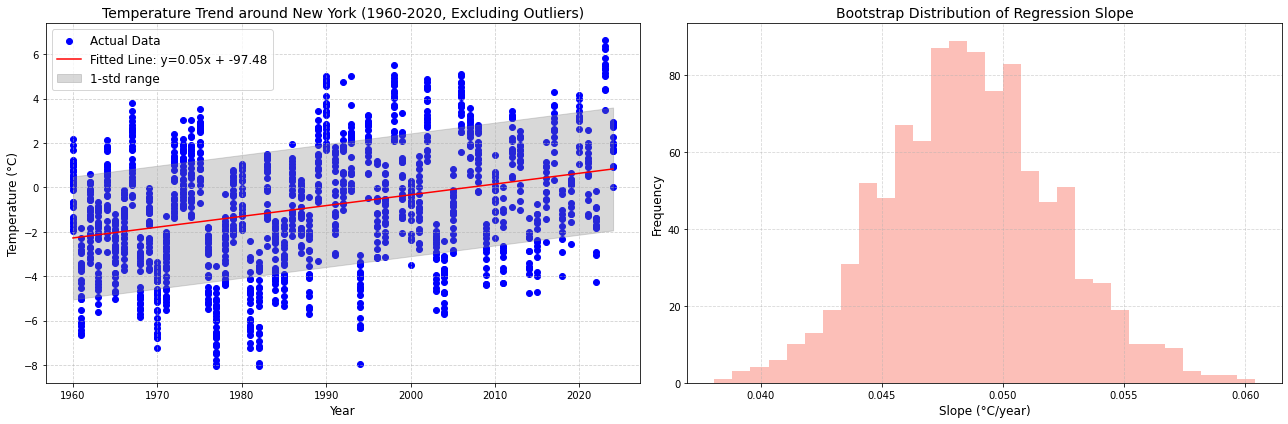


### Results for the Temperature Trend around New York City

- **Total Increase in Temperature (1960-2024):** 3.11 ± 0.05 °C  
- **Rate of Increase in Temperature (per year):** 0.05 °C/year  
- **Intercept:** -97.48 °C


In [6]:
# Plot fit results with data. Include results of Bootstrap errors
fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Left Plot: Temperature Trend
ax[0].scatter(filtered_years, filtered_temperatures, color='blue', label='Actual Data')  # Scatter plot
ax[0].plot(fitted_years, fitted_temperatures, color='red', label=f'Fitted Line: y={slope:.2f}x + {intercept:.2f}')  # Fitted line
ax[0].fill_between(fitted_years, std_lower_bound, std_upper_bound, color='gray', alpha=0.3, label='1-std range')  # 1-std shading
ax[0].set_title(f"Temperature Trend around {city_name} (1960-2020, Excluding Outliers)", fontsize=14)
ax[0].set_xlabel("Year", fontsize=12)
ax[0].set_ylabel("Temperature (°C)", fontsize=12)
ax[0].legend(fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Right Plot: Bootstrap Distribution
ax[1].hist(bootstrap_results["slopes"], bins=30, color='salmon', alpha=0.5)
ax[1].set_title("Bootstrap Distribution of Regression Slope", fontsize=14)
ax[1].set_xlabel("Slope (°C/year)", fontsize=12)
ax[1].set_ylabel("Frequency", fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Create a formatted markdown string
markdown_text = f"""
### Results for the Temperature Trend around {city_name} City

- **Total Increase in Temperature (1960-2024):** {round(total_increase, 2)} ± {round(err_slope, 2)} °C  
- **Rate of Increase in Temperature (per year):** {round(rate_of_increase, 2)} °C/year  
- **Intercept:** {round(intercept, 2)} °C
"""

display(Markdown(markdown_text))
